<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90086 entries, 0 to 90085
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   accountid             61386 non-null  float64       
 1   address               11940 non-null  object        
 2   amountnum             90086 non-null  float64       
 3   category              88891 non-null  object        
 4   categoryid            61386 non-null  float64       
 5   city                  28772 non-null  object        
 6   client_id             90086 non-null  object        
 7   country               85591 non-null  object        
 8   currency_code         61539 non-null  object        
 9   date                  90086 non-null  datetime64[ns]
 10  detail_category       58398 non-null  float64       
 11  high_level_category   60021 non-null  float64       
 12  latitude              11904 non-null  float64       
 13  longitude       

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52757 entries, 2020-08-20 to 2019-09-01
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   uid                 52757 non-null  object 
 1   category            52757 non-null  object 
 2   categoryid          52757 non-null  float64
 3   simple_description  52757 non-null  object 
 4   amountnum           52757 non-null  float64
 5   city                20462 non-null  object 
 6   state               25484 non-null  object 
 7   zip_code            13377 non-null  object 
 8   address             9188 non-null   object 
 9   latitude            9291 non-null   float64
 10  longitude           9291 non-null   float64
 11  accountid           52757 non-null  float64
dtypes: float64(5), object(7)
memory usage: 5.2+ MB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52262 entries, 2020-08-20 to 2019-09-01
Data columns (total 12 columns):
 #   Colum

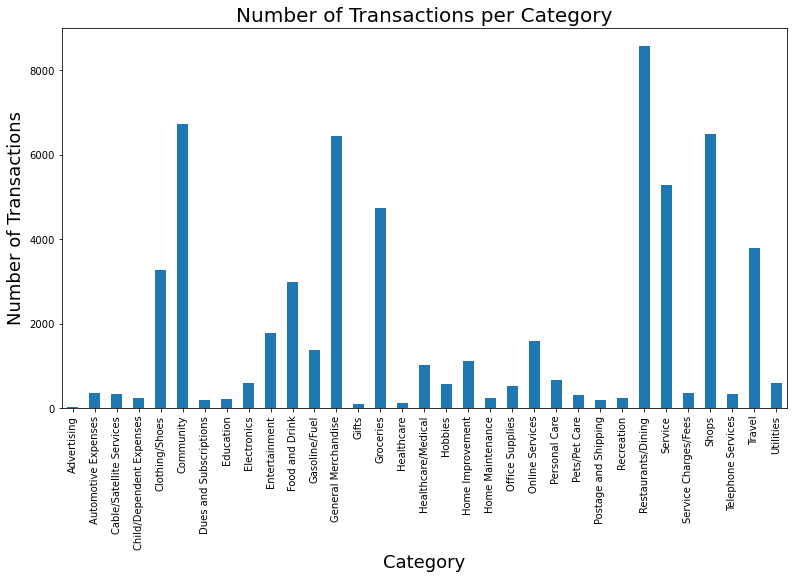

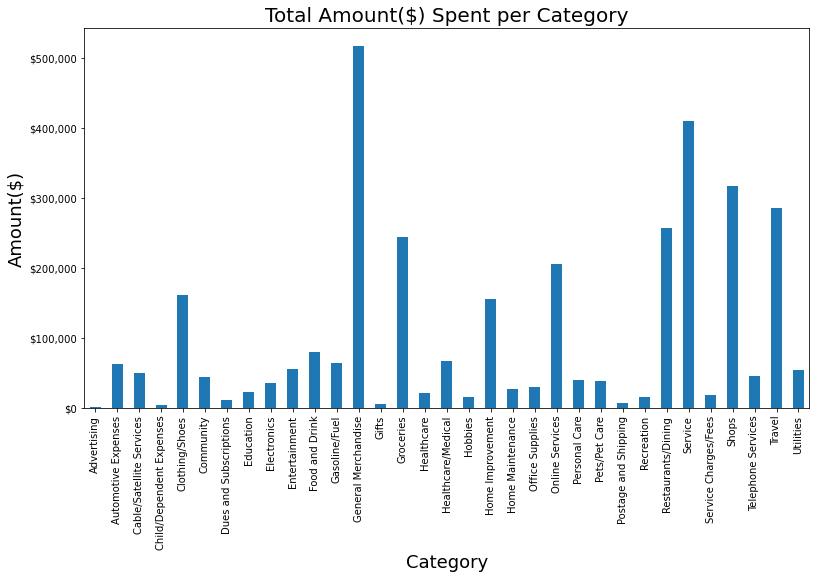

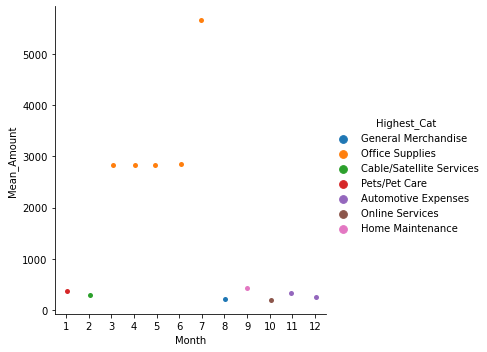

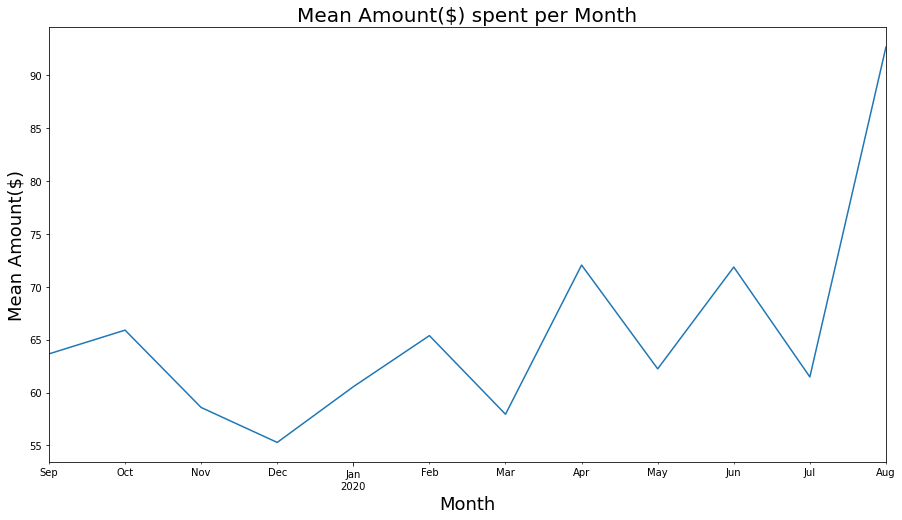

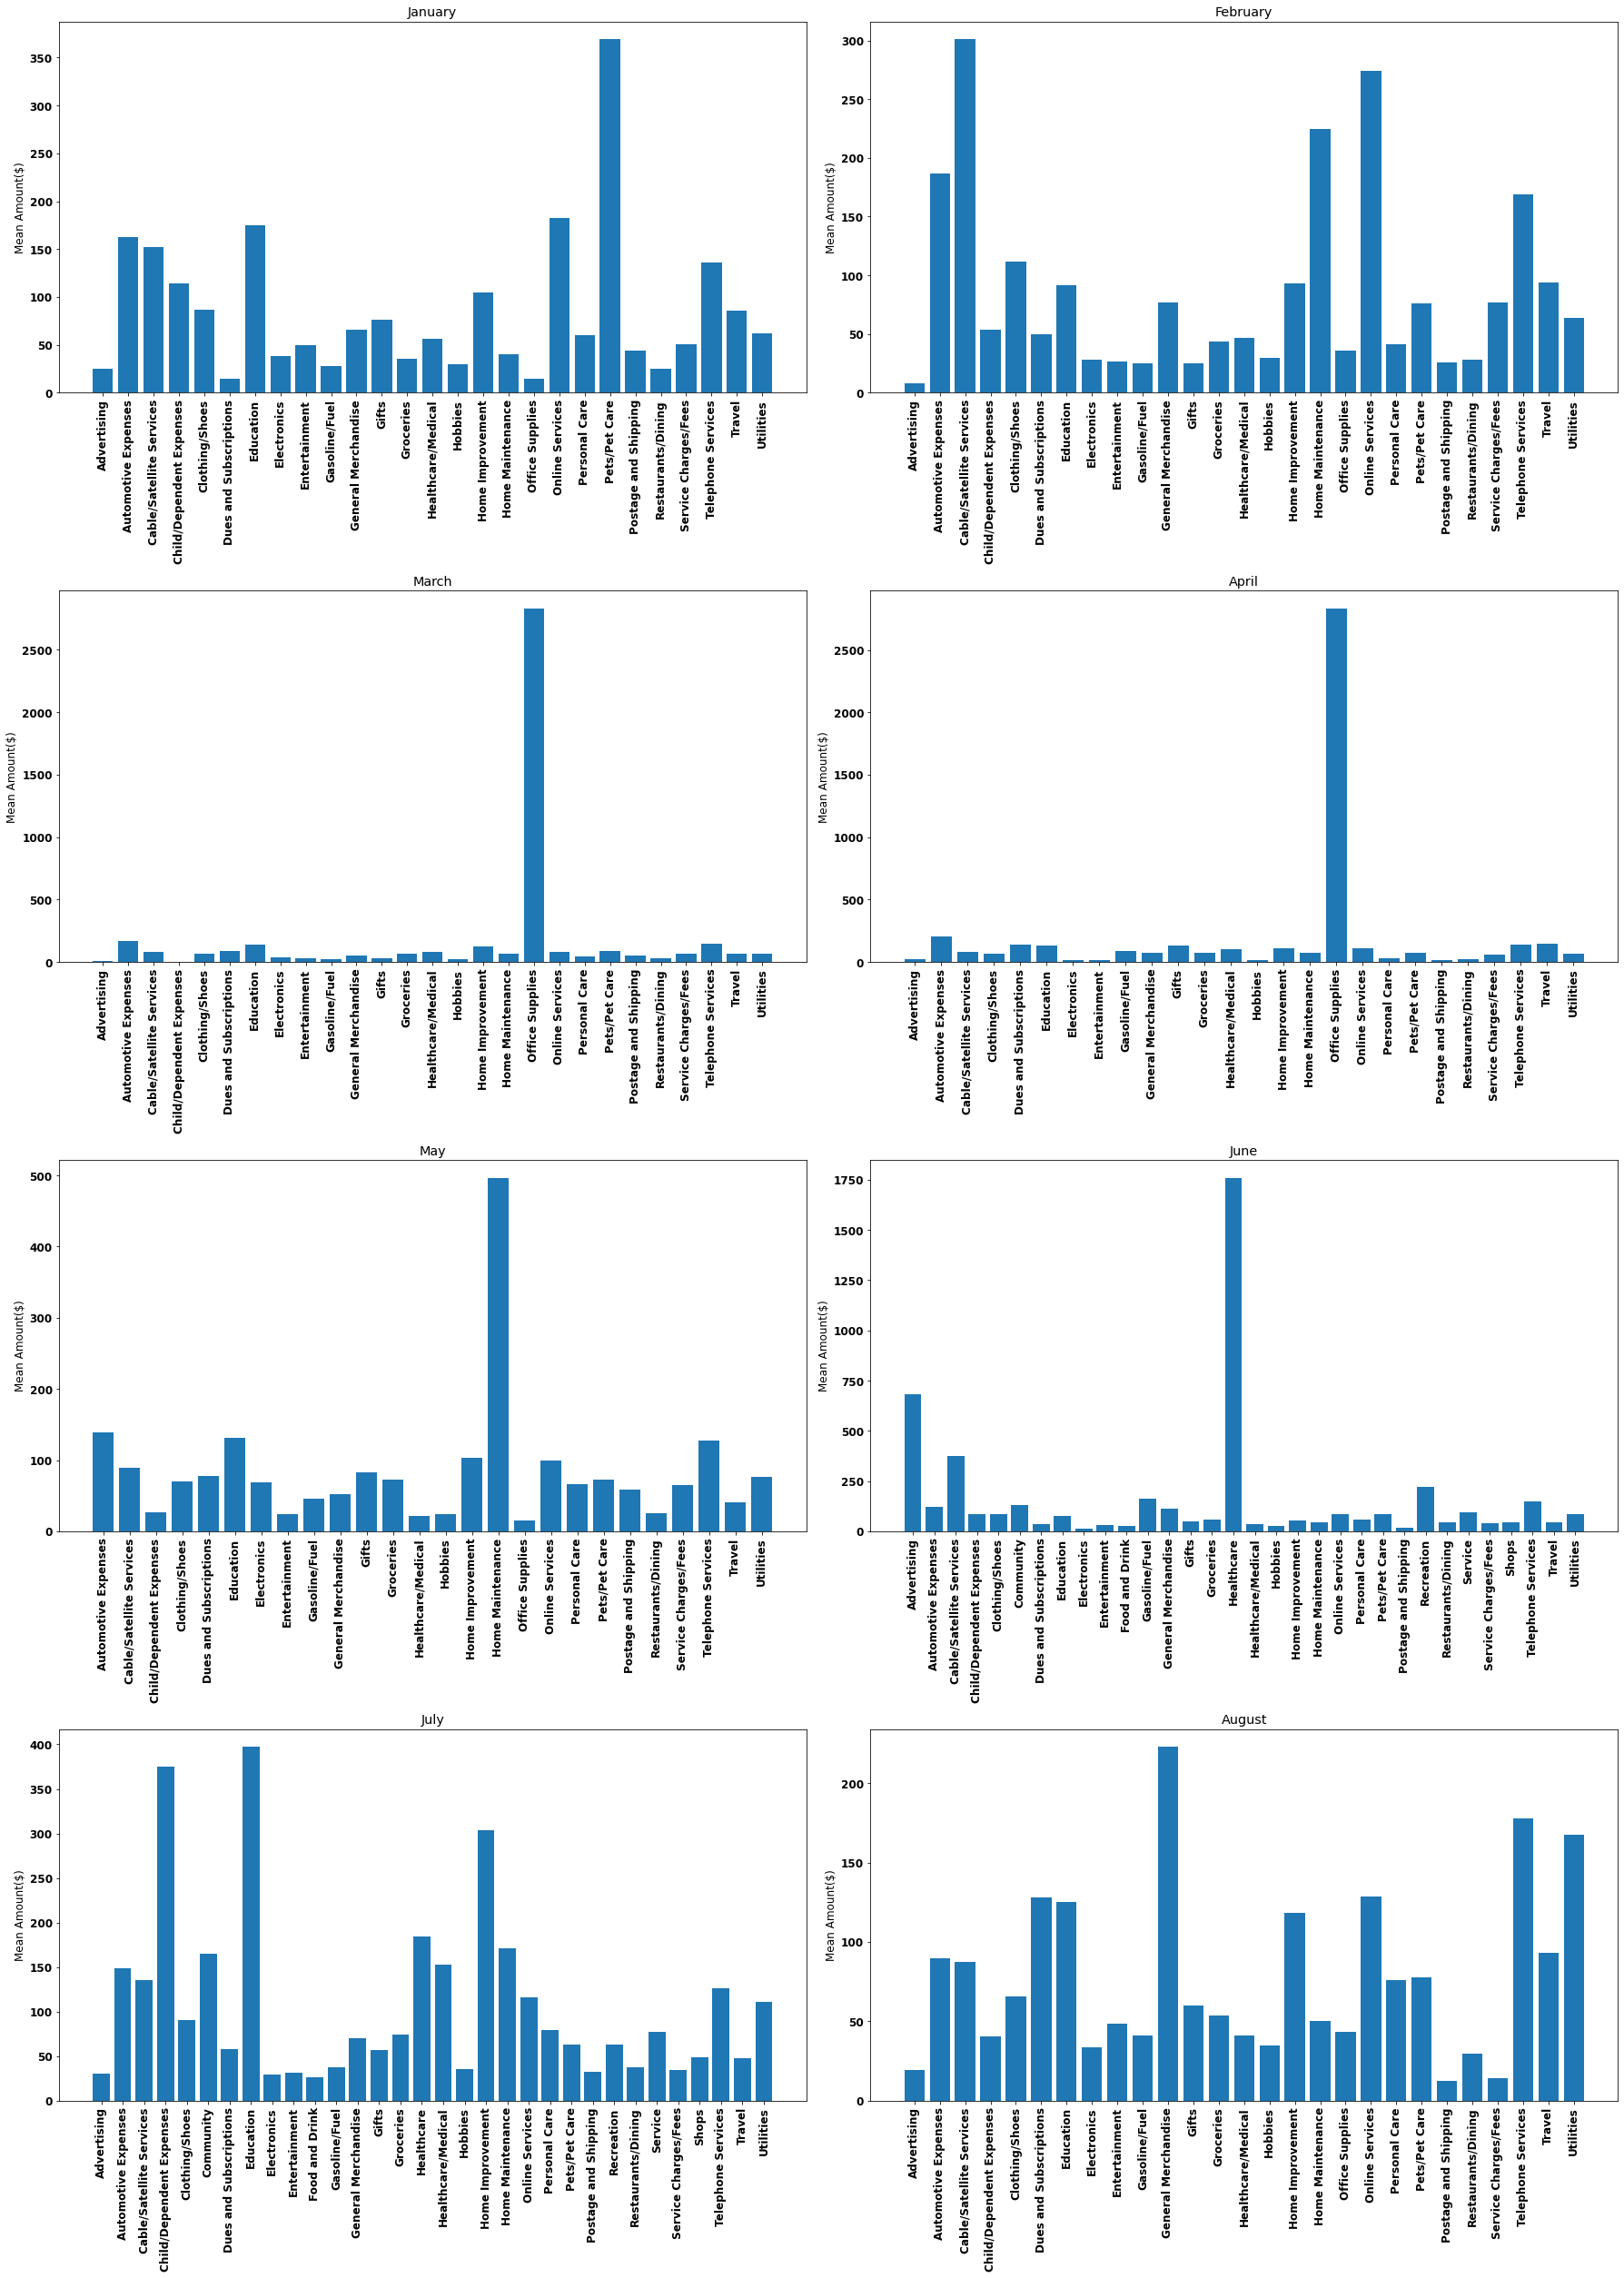

In [1]:
import pandas as pd
import EDA as eda

In [2]:
eda.df.shape

(52757, 13)

In [3]:
df1_rec=eda.df1

In [4]:
df1_rec.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52262 entries, 2020-08-20 to 2019-09-01
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   uid                 52262 non-null  object 
 1   category            52262 non-null  object 
 2   categoryid          52262 non-null  float64
 3   simple_description  52262 non-null  object 
 4   amountnum           52262 non-null  float64
 5   city                20340 non-null  object 
 6   state               25333 non-null  object 
 7   zip_code            13292 non-null  object 
 8   address             9134 non-null   object 
 9   latitude            9234 non-null   float64
 10  longitude           9234 non-null   float64
 11  accountid           52262 non-null  float64
dtypes: float64(5), object(7)
memory usage: 5.2+ MB


In [5]:
df1_rec=df1_rec.reset_index()

In [6]:
df1_rec.head(10)

,date,uid,category,categoryid,simple_description,amountnum,city,state,zip_code,address,latitude,longitude,accountid
0,2020-08-20,WdtUjyA3mghZ6TrphronQpCVrI23,Entertainment,7.0,sirius xm,20.63,NaN,None,NaN,None,NaN,NaN,10038937.0
1,2020-08-20,WdtUjyA3mghZ6TrphronQpCVrI23,Restaurants/Dining,22.0,*pending debit aug20 p 2818at buona glen ellyn...,20.69,Glen Ellyn,None,None,None,NaN,NaN,10038937.0
2,2020-08-20,WdtUjyA3mghZ6TrphronQpCVrI23,Groceries,10.0,the beer cellar,28.51,Glen Ellyn,None,None,None,NaN,NaN,10038937.0
3,2020-08-20,WdtUjyA3mghZ6TrphronQpCVrI23,Entertainment,7.0,disney plus,6.99,NaN,CA,NaN,None,NaN,NaN,10038937.0
4,2020-08-20,WdtUjyA3mghZ6TrphronQpCVrI23,Restaurants/Dining,22.0,p #2818christ cafe 95 oak lawn il x0232,1.09,Oak Lawn,IL,None,None,NaN,NaN,10038937.0
5,2020-08-20,WdtUjyA3mghZ6TrphronQpCVrI23,Gasoline/Fuel,8.0,shell,4.63,Lombard,IL,None,None,NaN,NaN,10038937.0
6,2020-08-20,WdtUjyA3mghZ6TrphronQpCVrI23,Groceries,10.0,jewel-osco,46.67,Glen Ellyn,IL,60137,599 east roosevelt road,41.8594,-88.04244,10038937.0
7,2020-08-20,WdtUjyA3mghZ6TrphronQpCVrI23,Gasoline/Fuel,8.0,shell,20.02,Lombard,IL,None,None,NaN,NaN,10038937.0
8,2020-08-20,A4Kyy9PFU7QLr08iECIlJOMI0zx2,Restaurants/Dining,22.0,chick-fil-a,12.22,Littleton,CO,None,None,NaN,NaN,10092987.0
9,2020-08-20,A4Kyy9PFU7QLr08iECIlJOMI0zx2,Restaurants/Dining,22.0,the original pancake house,18.00,Greenwood Village,CO,None,None,NaN,NaN,10092987.0


In [7]:
#Train/Test Data Split
##X_train,X_test, y_train, y_test =train_test_split(X,y, random_state=0)

#Question for Ana:
#1. How do I  use train_test_split in this situation? I am not sure what will y be? 
#2


In [8]:
df1_rec_mtx=df1_rec

In [9]:
df1_rec_mtx=df1_rec.pivot_table(index='uid',columns='categoryid', values='amountnum', aggfunc='mean')

In [10]:
df1_rec_mtx

categoryid,2.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,...,45.0,100.0,104.0,108.0,201.0,202.0,203.0,204.0,205.0,206.0
uid,,,,,,,,,,,,,,,,,,,,,
005vcYECEUZiN4cXajuea2lBnCy1,NaN,30.500,83.415652,54.6450,54.082000,25.830000,NaN,47.355000,22.9600,NaN,...,36.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0BvDU2CvJTPwox1OYT70bnWdDUB2,NaN,30.500,100.348750,61.8950,53.667500,25.316667,NaN,46.168636,25.0100,NaN,...,36.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0UIAYEH7qlUI6j1iiIg6XbmJWTG3,210.051429,95.826,65.464388,169.6524,20.936809,54.275930,89.4824,63.057833,170.5458,105.0,...,7.90,19.0,43.19875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1473824338217x786177262663841300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,37.537097,34.357455,30.881333,40.0,20.000000,34.99
1474388768309x409010901581496000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,28.760000,55.843214,52.631000,NaN,827.916667,29.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
xVIvGWUazLftKSenD2ozjaDN2ly2,7.250000,NaN,19.990000,16.1800,15.200000,22.910909,NaN,45.338889,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yQC8iKWHkfbah5VVg6uXcvwPors2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yZ8p33MBhcZSwkvUdnPFwnV1RR22,NaN,30.500,89.887391,54.6450,54.082000,25.830000,NaN,47.355000,21.7200,NaN,...,36.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df1_rec.groupby('categoryid')['simple_description'].count()

categoryid
2.0       348
4.0        55
5.0      1879
6.0       223
7.0      1755
8.0      1365
9.0       105
10.0     4720
11.0     1018
12.0      111
13.0     1121
15.0      315
16.0     1575
20.0      659
22.0     8530
23.0     3748
24.0      352
34.0      556
38.0      317
39.0      566
42.0      302
43.0      583
44.0     6369
45.0       63
100.0      14
104.0     201
108.0     176
201.0    6403
202.0    5266
203.0    2958
204.0     108
205.0     267
206.0     234
Name: simple_description, dtype: int64

In [12]:
df1_cat_catid_simple=df1_rec.groupby(['category','categoryid'])['simple_description'].count().to_frame()

In [13]:
df1_cat_catid_simple.sort_values('categoryid')

,,simple_description
category,categoryid,
Automotive Expenses,2.0,348
Child/Dependent Expenses,4.0,55
Clothing/Shoes,5.0,1879
Education,6.0,223
Entertainment,7.0,1755
Gasoline/Fuel,8.0,1365
Gifts,9.0,105
Groceries,10.0,4720
Healthcare/Medical,11.0,1018


In [14]:
#df1_rec[df1_rec.categoryid==2.0]

In [15]:
df1_rec[df1_rec.categoryid==2.0]['simple_description'].unique().tolist() #133 unique "names" in simple description

['east ******* car wash',
 'mobile from xx19 #xx8979',
 'ingles gas express',
 'mobile from xx19 #xx5141',
 'mobile from xx74 #xx5509',
 'rockstar',
 'mobile from xx22 #xx7688',
 'autozone',
 'coopers automotive',
 'mobile from xx85 #xx0071',
 'mobile from xx19 #xx4537',
 'mobile from xx22 #xx0718',
 'mobile from xx74 #xx0557',
 'mobile from xx19 #xx7565',
 'mobile from xx74 #xx6051',
 'ultra car wash',
 'honda',
 'gem car wash',
 'genuine parts company',
 'mobile from xx93 #xx5316',
 'mobile from xx22 #xx1698',
 'brite car wash',
 'chase',
 'sturdivants tire and a chapel hill nc',
 'sturdivants tire chapel hill nc',
 'shortstop gunbarrel car w',
 'goodyear',
 'rocky mountain whitewat',
 'the tire rack',
 'sq *niwot wheel wo niwot co sxx0654 card 9815',
 'auto air & vacuum service',
 'qwiklabs.com',
 'falls road auto ca baltimore md sxx2881 card 8563',
 'cowan tire of rutherfo',
 'dmv',
 'comotorveh comotorveh co.go($906.85)',
 'comotorveh co.go comotorveh',
 'bee clean auto wash',
 'c

In [16]:
df1_rec[df1_rec.categoryid==4.0]['simple_description'].nunique()

23

In [17]:
df1_rec[df1_rec.categoryid==4.0]['simple_description'].unique().tolist() #23 unique "names" in simple description

['once upon a child',
 'adventure academy',
 'childrens',
 'demme learning',
 'buy buy baby',
 'amz*yoee baby llc',
 'bedford center',
 'sp * build a bowtique httpsbuildabofl',
 'learning express toys',
 'p #4120dupagechildrensmus naperville il x0041',
 '******* care',
 'aarp',
 'dreamland',
 'carroll place',
 'witch baby soap',
 'sticker mule',
 "the children's place",
 "grandrabbit's toy shoppe",
 'care.com',
 "carter's",
 'toyzam',
 'p #2818dupagechildrensmus naperville il x9285',
 'p #2818dupagechildrensmus naperville il x9278']

In [18]:
#Resturants/Dinning
df1_rec[df1_rec.categoryid==22.0]['simple_description'].nunique()

2549

In [19]:
resturant_list=df1_rec[df1_rec.categoryid==22.0]['simple_description'].unique().tolist()

In [20]:
for rest in resturant_list:
    if rest[0]== '\"':
        print(rest)
#(rest[0:7]=='pending') or
#(rest[0:2]=='pp')



In [21]:
df1_rec_resturants=df1_rec[df1_rec.categoryid==22.0]

In [22]:
df1_rec_resturants.reset_index(inplace=True,drop=True)
df1_rec_resturants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8530 entries, 0 to 8529
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                8530 non-null   datetime64[ns]
 1   uid                 8530 non-null   object        
 2   category            8530 non-null   object        
 3   categoryid          8530 non-null   float64       
 4   simple_description  8530 non-null   object        
 5   amountnum           8530 non-null   float64       
 6   city                4600 non-null   object        
 7   state               4521 non-null   object        
 8   zip_code            3041 non-null   object        
 9   address             1801 non-null   object        
 10  latitude            1815 non-null   float64       
 11  longitude           1815 non-null   float64       
 12  accountid           8530 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(7)
memo

In [28]:
df1_rec_resturants.head(10)

,date,uid,category,categoryid,simple_description,amountnum,city,state,zip_code,address,latitude,longitude,accountid
0,2020-08-20,WdtUjyA3mghZ6TrphronQpCVrI23,Restaurants/Dining,22.0,*pending debit aug20 p 2818at buona glen ellyn...,20.69,Glen Ellyn,None,None,None,NaN,NaN,10038937.0
1,2020-08-20,WdtUjyA3mghZ6TrphronQpCVrI23,Restaurants/Dining,22.0,p #2818christ cafe 95 oak lawn il x0232,1.09,Oak Lawn,IL,None,None,NaN,NaN,10038937.0
2,2020-08-20,A4Kyy9PFU7QLr08iECIlJOMI0zx2,Restaurants/Dining,22.0,chick-fil-a,12.22,Littleton,CO,None,None,NaN,NaN,10092987.0
3,2020-08-20,A4Kyy9PFU7QLr08iECIlJOMI0zx2,Restaurants/Dining,22.0,the original pancake house,18.00,Greenwood Village,CO,None,None,NaN,NaN,10092987.0
4,2020-08-20,kSCSRuyQqWOxp0kPlXwwF0dmhQ02,Restaurants/Dining,22.0,sq *world's end brewin,63.49,NaN,None,NaN,None,NaN,NaN,10293258.0
5,2020-08-20,kSCSRuyQqWOxp0kPlXwwF0dmhQ02,Restaurants/Dining,22.0,breakfast on broadway,49.15,NaN,None,NaN,None,NaN,NaN,10293258.0
6,2020-08-20,0UIAYEH7qlUI6j1iiIg6XbmJWTG3,Restaurants/Dining,22.0,chick-fil-a,12.21,Longmont,CO,80501,215 ken pratt boulevard,40.15203,-105.09626,10041637.0
7,2020-08-20,0UIAYEH7qlUI6j1iiIg6XbmJWTG3,Restaurants/Dining,22.0,illegal petes,13.94,NaN,None,NaN,None,NaN,NaN,10041637.0
8,2020-08-20,0UIAYEH7qlUI6j1iiIg6XbmJWTG3,Restaurants/Dining,22.0,starbucks,9.12,Longmont,CO,80501,2318 17th avenue,40.18910,-105.12987,10041637.0
9,2020-08-20,0UIAYEH7qlUI6j1iiIg6XbmJWTG3,Restaurants/Dining,22.0,jefes tacos & tequila,40.15,NaN,None,NaN,None,NaN,NaN,10041637.0


In [25]:
df1_rec_resturants[df1_rec_resturants.simple_description=='p #2818christ cafe 95 oak lawn il x0232']

,date,uid,category,categoryid,simple_description,amountnum,city,state,zip_code,address,latitude,longitude,accountid
1,2020-08-20,WdtUjyA3mghZ6TrphronQpCVrI23,Restaurants/Dining,22.0,p #2818christ cafe 95 oak lawn il x0232,1.09,Oak Lawn,IL,None,None,NaN,NaN,10038937.0


In [27]:
df1_rec_resturants[8528:]

,date,uid,category,categoryid,simple_description,amountnum,city,state,zip_code,address,latitude,longitude,accountid
8528,2019-09-01,VtdpeFkK9me5g2JkHXRl4puc8Bw2,Restaurants/Dining,22.0,watusi cafe hilton head sc,6.05,Hilton Head Island,SC,29926,None,NaN,NaN,10018258.0
8529,2019-09-01,VtdpeFkK9me5g2JkHXRl4puc8Bw2,Restaurants/Dining,22.0,mcdonald's,4.10,Yemassee,SC,None,None,NaN,NaN,10018258.0


In [31]:
rest_list=[]
for merch in df1_rec_resturants.simple_description:
    if ((merch[0:8]=='*pending')):
        rest_list.append(merch[30:])
    elif (merch[0:7]=='pending'):
        rest_list.append(merch[19:])
    elif (merch[0:2]=='p '):
        rest_list.append(merch[7:])
    elif (merch[0:2]=='pp'):
        rest_list.append(merch[3:])
    #elif (merch=="mcdonald's"):
        #rest_list.append('MCD')
    else:
        rest_list.append(merch)
        
pd.Series(rest_list)

0          buona glen ellyn # glen ellyn
1       christ cafe 95 oak lawn il x0232
2                            chick-fil-a
3             the original pancake house
4                 sq *world's end brewin
                      ...               
8525                          mcdonald's
8526                        saigon basil
8527                          sushi guru
8528          watusi cafe hilton head sc
8529                          mcdonald's
Length: 8530, dtype: object

In [32]:
df1_rec_resturants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8530 entries, 0 to 8529
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                8530 non-null   datetime64[ns]
 1   uid                 8530 non-null   object        
 2   category            8530 non-null   object        
 3   categoryid          8530 non-null   float64       
 4   simple_description  8530 non-null   object        
 5   amountnum           8530 non-null   float64       
 6   city                4600 non-null   object        
 7   state               4521 non-null   object        
 8   zip_code            3041 non-null   object        
 9   address             1801 non-null   object        
 10  latitude            1815 non-null   float64       
 11  longitude           1815 non-null   float64       
 12  accountid           8530 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(7)
memo

In [33]:
#df1_rec_resturants['merchant']=pd.Series(rest_list)


df1_rec_resturants.loc[:,'merchant'] = pd.Series(rest_list, index=df1_rec_resturants.index)
df1_rec_resturants

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,date,uid,category,categoryid,simple_description,amountnum,city,state,zip_code,address,latitude,longitude,accountid,merchant
0,2020-08-20,WdtUjyA3mghZ6TrphronQpCVrI23,Restaurants/Dining,22.0,*pending debit aug20 p 2818at buona glen ellyn...,20.69,Glen Ellyn,None,None,None,NaN,NaN,10038937.0,buona glen ellyn # glen ellyn
1,2020-08-20,WdtUjyA3mghZ6TrphronQpCVrI23,Restaurants/Dining,22.0,p #2818christ cafe 95 oak lawn il x0232,1.09,Oak Lawn,IL,None,None,NaN,NaN,10038937.0,christ cafe 95 oak lawn il x0232
2,2020-08-20,A4Kyy9PFU7QLr08iECIlJOMI0zx2,Restaurants/Dining,22.0,chick-fil-a,12.22,Littleton,CO,None,None,NaN,NaN,10092987.0,chick-fil-a
3,2020-08-20,A4Kyy9PFU7QLr08iECIlJOMI0zx2,Restaurants/Dining,22.0,the original pancake house,18.00,Greenwood Village,CO,None,None,NaN,NaN,10092987.0,the original pancake house
4,2020-08-20,kSCSRuyQqWOxp0kPlXwwF0dmhQ02,Restaurants/Dining,22.0,sq *world's end brewin,63.49,NaN,None,NaN,None,NaN,NaN,10293258.0,sq *world's end brewin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8525,2019-09-01,TESTUIDcuatro,Restaurants/Dining,22.0,mcdonald's,4.10,Yemassee,SC,None,None,NaN,NaN,10018256.0,mcdonald's
8526,2019-09-01,jA8Rm4XLjKNskb7A8Gn80ak5WWJ3,Restaurants/Dining,22.0,saigon basil,28.99,Northglenn,CO,80234,10665 Melody Dr,39.889923,-104.993401,10042530.0,saigon basil
8527,2019-09-01,VtdpeFkK9me5g2JkHXRl4puc8Bw2,Restaurants/Dining,22.0,sushi guru,14.08,Charlotte,NC,28211,6601 Morrison Blvd,35.153833,-80.827895,10018258.0,sushi guru
8528,2019-09-01,VtdpeFkK9me5g2JkHXRl4puc8Bw2,Restaurants/Dining,22.0,watusi cafe hilton head sc,6.05,Hilton Head Island,SC,29926,None,NaN,NaN,10018258.0,watusi cafe hilton head sc


In [52]:
count_per_merch=df1_rec_resturants.groupby(['merchant'])['merchant'].count()
count_per_merch

merchant
#4120door county coffee & t                         1
#4120summer kitchen restaur                         1
#4120tst* mikerphone brewin xx98 il x0119           1
#4120woodgrain pizzeria gle glen ellyn il x0193     1
******* bbq                                         4
                                                   ..
zo sushi and thai                                   1
zoe's kitchen                                      18
zucca bar & pizzeria                                3
zucca bar pizzeri                                   1
zum duernbraeu                                      1
Name: merchant, Length: 2488, dtype: int64

In [35]:
df1_rec_merch_mtx=df1_rec_resturants.pivot_table(index='uid',columns='merchant', values='amountnum', aggfunc='count')
df1_rec_merch_mtx

merchant,#4120door county coffee & t,#4120summer kitchen restaur,#4120tst* mikerphone brewin xx98 il x0119,#4120woodgrain pizzeria gle glen ellyn il x0193,******* bbq,******* brewing,******* creek chinescolorado sp xx81,******* creek chinese restaurant,******* in the box,******* pizza co.,...,ziggi's coffee house,ziggis coffee,ziggis coffee - lo louisville co sxx2716 card 9815,ziggis coffee - main s,ziggy's,zo sushi and thai,zoe's kitchen,zucca bar & pizzeria,zucca bar pizzeri,zum duernbraeu
uid,,,,,,,,,,,,,,,,,,,,,
005vcYECEUZiN4cXajuea2lBnCy1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0BvDU2CvJTPwox1OYT70bnWdDUB2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0UIAYEH7qlUI6j1iiIg6XbmJWTG3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,46.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN
1I87ooK6OBNwxmmA31vkOHwA8wB3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1fPMZehrbgWogwknDB4ZKluoVFg2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,9.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wrHJZ3ZqRaO9VIPd55VTs6qHOpt2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xVIvGWUazLftKSenD2ozjaDN2ly2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yZ8p33MBhcZSwkvUdnPFwnV1RR22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
rest_user_visited="mcdonald's"


#Tortas_ratings = places_crosstab[135085]
#Tortas_ratings[Tortas_ratings>=0]

In [45]:
Resturant_popularity=df1_rec_merch_mtx["ziggy's"]
Resturant_popularity[Resturant_popularity>=0]

uid
qjTs2etDNnc9mSlIVQDDMUAh5xU2    1.0
Name: ziggy's, dtype: float64

In [46]:
Resturant_popularity=df1_rec_merch_mtx[rest_user_visited]
Resturant_popularity[Resturant_popularity>=0]

uid
0UIAYEH7qlUI6j1iiIg6XbmJWTG3    36.0
1I87ooK6OBNwxmmA31vkOHwA8wB3     3.0
5TZ24fWpnyeVX2yEOSWtEgINSMC2     5.0
6KgQR8On4dbB4iOhTmspFs15rC82     1.0
9PV219z13pMFPKV7q1VOXXvMnzB3     9.0
A4Kyy9PFU7QLr08iECIlJOMI0zx2    18.0
DBVvUVdp3WU4dEvFMgLIhyFEnhx2     8.0
LLj3e1zlJnNRbLkSyuIqaDW7hWi2     4.0
MbXxOc9yrRdIw4OKL4rBgD7z2dr2     3.0
Nz83cnnZytZoKK4VFmuPc0M6HPw2     2.0
O9RMoXl5RLPtmC46bllPHNB7py52     3.0
PlivnaMFITNbNHGJgdusJrKy93u1    13.0
RzVNsBQRKjTf9I9FOD3XyNpSQ743     1.0
TESTUIDcuatro                    1.0
U8kKubAQuvNqWx25gcHRo5KfAle2     6.0
UXga4vtQOePP2eBMS3HRRmhGTwu2     2.0
VtdpeFkK9me5g2JkHXRl4puc8Bw2     3.0
Vu3NDutPceaAEeiGqONoQG7dDou1    11.0
WS6NUeALoRRxZzncJ8aY0vNIDwu1     1.0
WdtUjyA3mghZ6TrphronQpCVrI23     4.0
ZbJHQYHchNRMpoz8hNvRNqjs9Cz2     1.0
eRz0pZkb8WYiEYRdOftsZN3Qj5r2     1.0
ijLhZoMeT9NG2Pwcr5da2EB3NMr1    13.0
imOgmCoYovf6P76NIjGnZhqySkj1     1.0
jA8Rm4XLjKNskb7A8Gn80ak5WWJ3     8.0
kSCSRuyQqWOxp0kPlXwwF0dmhQ02    13.0
oO6DTnMgI0VLmOpiR1DpFglAgG72     3

In [47]:
## Evaluating Similarity Based on Correlation

In [48]:
similar_to_resturant = df1_rec_merch_mtx.corrwith(Resturant_popularity)

similar_to_resturant

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


merchant
#4120door county coffee & t                             NaN
#4120summer kitchen restaur                             NaN
#4120tst* mikerphone brewin xx98 il x0119               NaN
#4120woodgrain pizzeria gle glen ellyn il x0193         NaN
******* bbq                                             NaN
                                                     ...   
zo sushi and thai                                       NaN
zoe's kitchen                                      0.693375
zucca bar & pizzeria                                    NaN
zucca bar pizzeri                                       NaN
zum duernbraeu                                          NaN
Length: 2488, dtype: float64

In [50]:
corr_resturant = pd.DataFrame(similar_to_resturant, columns=['PearsonR'])
corr_resturant.dropna(inplace=True)
corr_resturant

,PearsonR
merchant,
andy's frozen custard,1.000000
aramark,-0.818182
arby's,0.523752
atlanta tech village,-1.000000
bang bang burgers,1.000000
...,...
which wich superior sandwiches,0.755929
wolfgang puck,1.000000
zaxby's,0.105830


In [53]:
resturant_corr_summary = corr_resturant.join(count_per_merch)

In [58]:
resturant_corr_summary.rename(columns={"merchant": "Num_Times_Merch_Was_Visited"}, inplace=True)
resturant_corr_summary

,PearsonR,Num_Times_Merch_Was_Visited
merchant,,
andy's frozen custard,1.000000,5
aramark,-0.818182,11
arby's,0.523752,13
atlanta tech village,-1.000000,8
bang bang burgers,1.000000,8
...,...,...
which wich superior sandwiches,0.755929,6
wolfgang puck,1.000000,3
zaxby's,0.105830,10


In [67]:
final_recommendation=resturant_corr_summary[resturant_corr_summary['Num_Times_Merch_Was_Visited']>=10].sort_values('PearsonR', ascending=False).head(3)
final_recommendation.index.tolist()

['pret a manger', 'roti chi lake', 'dutch bros. coffee']

In [ ]:
#>>> print('We are the {} who say "{}!"'.format('knights', 'Ni'))
#We are the knights who say "Ni!

In [70]:
print("Since you visited {}, we recommend you visit these {} places in future".format(rest_user_visited, final_recommendation.index.tolist()))

Since you visited mcdonald's, we recommend you visit these ['pret a manger', 'roti chi lake', 'dutch bros. coffee'] places in future


In [ ]:
####yahoooooo!!!!!